In [5]:
import random
from functools import partial
from pathlib import Path

from matplotlib.pyplot import figure, plot
from torch import Generator, Tensor, histogram, tensor, use_deterministic_algorithms

from karpathy_series.makemore.bigrams import NGram
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.components.neuro.functional import Functional
from karpathy_series.makemore.components.neuro.sequence import Sequence
from karpathy_series.makemore.components.generation import NGramNetGenerator
from karpathy_series.makemore.components.networks.mlp import MPLNet
from karpathy_series.makemore.training.data import DataSplit, TrainingSequencer
from karpathy_series.makemore.training.learning import Learner, LearningRecord
from karpathy_series.makemore.util import karpathy_generator, set_rand_karpathy

%matplotlib inline
use_deterministic_algorithms(True)
set_rand_karpathy()

In [6]:
data_path = Path("../../data/names.txt")
words = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 8
embedding_dims = 10
hidden_dims = 200

n_gram_gen = partial(NGram.generate, context_size, char_set.pad)
ts = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)
data_split = DataSplit.split(words, 80, 10, 10)
learning_sequence = ts.training_sequence(data_split.training, 32, True)
validation_set = ts.training_set(data_split.validation)

In [7]:
main_window = tensor(range(48)).view(2, 8, 3)
a = main_window.view(2, 4, 2, 3)

# The schema here is to expand at dim=1 after the main batch dimension
b = main_window.unflatten(1, (-1, 2))
assert (a == b).all().item()

In [33]:
from operator import mul
from functools import reduce
from torch import prod
main_window = tensor(range(5*2*8*3*4)).view(5, 2, 8, 3, 4)
#a = main_window.view(2, 4, 2, 3)
#a.shape

dim = 2
factor = 2

s = main_window.shape
pre = s[:dim]
f = s[dim]
post = s[dim+1:]
print(f"{pre} - {f} - {post}")

fp = f // factor
l = reduce(mul, post, 1)*factor

print(fp, l)

v = pre + (fp, l)
print(v)



torch.Size([5, 2]) - 8 - torch.Size([3, 4])
4 24
torch.Size([5, 2, 4, 24])


In [8]:
from karpathy_series.makemore.components.neuro.embedding import Embedding
from karpathy_series.makemore.components.neuro.expand import Expand
from karpathy_series.makemore.components.neuro.flatten import Flatten
from karpathy_series.makemore.components.neuro.functional import Tanh
from karpathy_series.makemore.components.neuro.linear import Linear

code_size = 5
in_dims = 2
input_len = 15
grouping_size = 3
group_count = input_len // grouping_size
layer_2 = 4
layers = [
    # N[s, l] => R[s, l, d]
    Embedding(code_size, in_dims),

    # R[s, l, d] => R[s, g, c, d], l = gc
    Expand(1, grouping_size),

    # R[s, g, c, d] => R[s, g, cd]
    Flatten(2),

    # R[s, g, cd] => R[s, g, v]
    Linear(grouping_size * in_dims, layer_2),

    # Pointwise
    Tanh(),

    # R[s, g, v] => R[s, gv]
    Flatten(2),
    
    # R[s, gv] => R[s, o]
    Linear(group_count * layer_2, 4),
]

x_in = tensor([[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]])

x = x_in
print(x.shape)
for l in layers:
    x = l(x)
    print(x.shape, l.describe())

torch.Size([2, 15])
torch.Size([2, 15, 2]) Embedding [5, 2]
torch.Size([2, 5, 3, 2]) Expand dim 1 into 3 sized batches
torch.Size([2, 5, 6]) Flatten last 2 dims
torch.Size([2, 5, 4]) Linear [6, 4] with bias
torch.Size([2, 5, 4]) Functional <built-in method tanh of type object at 0x7ff43d13ecc0>
torch.Size([2, 20]) Flatten last 2 dims
torch.Size([2, 4]) Linear [20, 4] with bias


In [20]:
net = Sequence([
    Embedding(char_encoder.size, embedding_dims),
])
print(net.describe())

Sequence [Embedding [27, 10]]


In [18]:
g = rand_generator.manual_seed(seed)
mpl_net = MPLNet.init(4, char_encoder.size, embedding_dims, context_size, hidden_dims, g)
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, mpl_net)
learning_record = LearningRecord()
print(f"{mpl_net.layers.size()} parameters")
print(f"{mpl_net.layers.describe()} parameters")

144151 parameters
Sequence [Embedding [27, 10], Flatten last 2 dims, Linear [80, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f49b7e149e0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f49b7e149e0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f49b7e149e0>, Linear [200, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f49b7e149e0>, Linear [200, 27] with bias, BatchNorm1d [27]] parameters


In [23]:
learner = Learner(mpl_net, 0.01)
learning_record += learner(learning_sequence, epochs=10, report_epochs=1)

Epoch 1 is finished with loss =  1.9337
Epoch 2 is finished with loss =  1.9455
Epoch 3 is finished with loss =  1.8759
Epoch 4 is finished with loss =  1.7998
Epoch 5 is finished with loss =  1.8964
Epoch 6 is finished with loss =  1.9587
Epoch 7 is finished with loss =  1.9151
Epoch 8 is finished with loss =  2.0770
Epoch 9 is finished with loss =  1.8811
Epoch 10 is finished with loss =  1.9237


In [24]:
print(mpl_net.run(*validation_set))

tensor(2.0294, grad_fn=<NllLossBackward0>)


In [25]:
for k in range(20):
    print(generator())

brenley
myruse
desua
marlene
lydeah
adregs
erangley
oriya
nichry
lavis
minhka
valloy
magdyne
allaryah
joiam
quitae
mykeah
aileena
leigh
jaigo


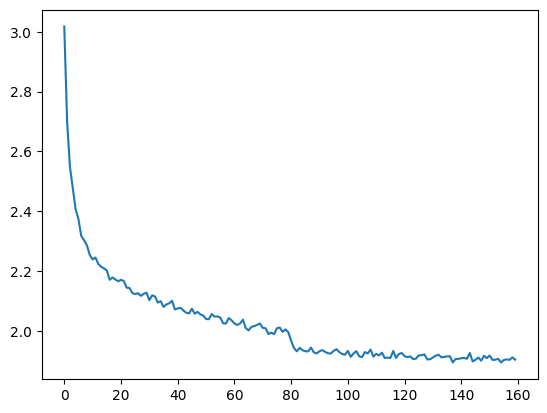

In [28]:
plot(tensor(learning_record.loss[: len(learning_record.loss) // 100 * 100]).view(-1, 100).mean(1))

In [ ]:
record = ComponentRecorder()
loss = mpl_net.step(*next(learning_sequence()), record=record)
print(f"Step loss = {loss: .4f}")

In [ ]:
def saturation(out: Tensor) -> float:
    return (out.abs() > 0.97).float().mean()


figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.mean(): .4f}, std {out.std(): .4f}, saturation {saturation(out): .2%}")
        hy, hx = histogram(out, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

In [ ]:
figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.grad.mean(): .4f}, std {out.grad.std(): .4f}")
        hy, hx = histogram(out.grad, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

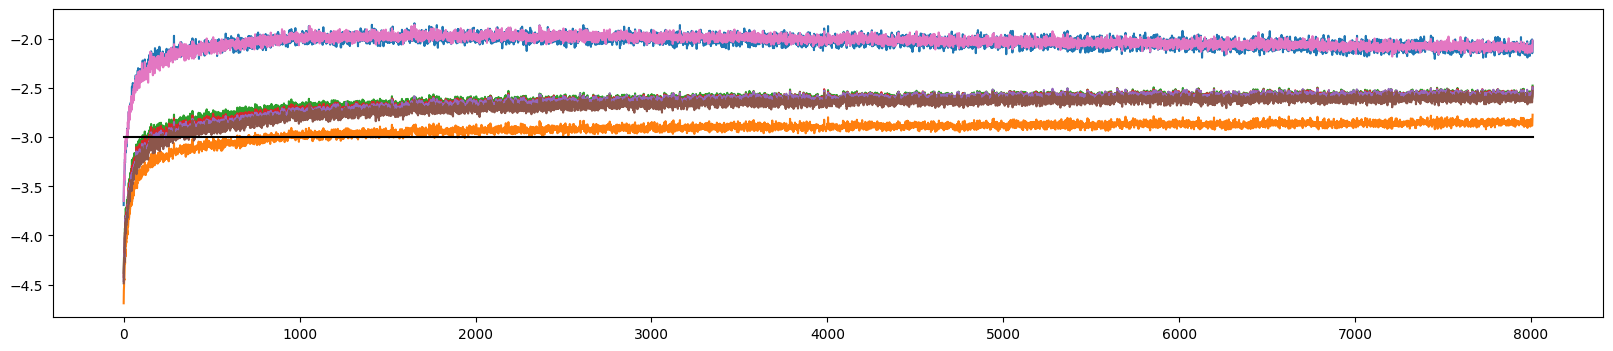

In [7]:
figure(figsize=(20, 4))
legends = []
for i, p in enumerate(mpl_net.parameters()):
    if p.ndim == 2:
        plot([learning_record.update_ratios[j][i] for j in range(len(learning_record.update_ratios))])
        legends.append(f"param {i}")
plot([0, len(learning_record.update_ratios)], [-3, -3], "k")